# 1083 Albumin Initial ML

### By: Ian Weimer

In [102]:
import imblearn
print("Imbalanced-Learn", imblearn.__version__)

Imbalanced-Learn 0.7.0


In [103]:
#print("Imbalanced-Learn", imbalanced-learn.__version__)

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('N04_matched.csv')

In [3]:
df.CCI.value_counts()

0     786
4     489
5     462
3     397
2     275
6     217
1     212
7     119
8      85
9      40
10     30
11     11
13      7
14      5
12      4
Name: CCI, dtype: int64

In [4]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [5]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   propensity_score  propensity_logit  albumin_24hrs  \
0          0.635797          0.557167              1   
1          0.370413         -0.530446              1   
2          0.855310          1.776873              1   
3          0.671801          0.716343              1   
4          0.676695          0.738624              1   

                               personid  LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8  0.743750                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892  6.963056                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9  4.140972                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd  1.348611                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870  9.985417                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [6]:
df.shape

(3139, 16)

In [7]:
df.propensity_logit.describe()

count    3139.000000
mean        0.352949
std         0.867150
min        -0.552736
25%        -0.526054
50%         0.396354
75%         0.720809
max         3.377556
Name: propensity_logit, dtype: float64

## Add ICU-variable based dataframes

### ICU Cohort

### Non ICU Cohort

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [8]:
m_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_mortality'].value_counts()
print(m_90d_a24)

0    1454
1     116
Name: 90_day_mortality, dtype: int64


In [9]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(m_90d_a24)

7.388535031847134

In [10]:
m_90d = df[df['albumin_24hrs'] == 0]['90_day_mortality'].value_counts()
print(m_90d)

0    1480
1      89
Name: 90_day_mortality, dtype: int64


In [11]:
binary_pct(m_90d)

5.672402804333971

In [12]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   propensity_score  propensity_logit  albumin_24hrs  \
0          0.635797          0.557167              1   
1          0.370413         -0.530446              1   
2          0.855310          1.776873              1   
3          0.671801          0.716343              1   
4          0.676695          0.738624              1   

                               personid  LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8  0.743750                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892  6.963056                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9  4.140972                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd  1.348611                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870  9.985417                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [13]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit', 'albumin', 'albumin_timing'], inplace=True)

In [14]:
df.drop(columns=['90_day_readmission', 'LOS_days', 'hospital_free_days'], inplace=True)

In [15]:
# df.drop(columns=['MELD'], inplace=True)

In [16]:
df.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs  90_day_mortality
0    0          0    0      1     2              1                 0
1    0          0    1      0     0              1                 0
2    0          1    0      1     2              1                 0
3    0          0    0      1     3              1                 0
4    0          0    4      1     3              1                 0

In [17]:
# remove non-baseline variables

# df.drop(columns=['beta_blocker', 'bl_albumin_value', 'SAPS', 'qSOFA'], inplace=True)

In [18]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  3139.000000  3139.000000  3139.000000  3139.000000  3139.000000   
mean      0.109908     0.204205     3.193374     0.461612     1.093979   
std       0.312824     0.403184     2.626143     0.596389     1.457632   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     0.000000     1.000000   
75%       0.000000     0.000000     5.000000     1.000000     2.000000   
max       1.000000     1.000000    14.000000     3.000000    10.000000   

       albumin_24hrs  90_day_mortality  
count    3139.000000       3139.000000  
mean        0.500159          0.065307  
std         0.500080          0.247107  
min         0.000000          0.000000  
25%         0.000000          0.000000  
50%         1.000000          0.000000  
75%         1.000000          0.000000  
max         1.000000          1.000000

In [19]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

In [20]:
df['90_day_mortality'].value_counts()

0    2934
1     205
Name: 90_day_mortality, dtype: int64

In [22]:
# df[df['albumin_24hrs'] == 1]['MELD'].describe()

In [23]:
# df[df['albumin_24hrs'] == 0]['MELD'].describe()

In [24]:
df[df['albumin_24hrs'] == 1]['CCI'].describe()

count    1570.000000
mean        2.669427
std         2.846781
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        14.000000
Name: CCI, dtype: float64

In [25]:
df[df['albumin_24hrs'] == 0]['CCI'].describe()

count    1569.000000
mean        3.717655
std         2.267776
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        14.000000
Name: CCI, dtype: float64

## Modeling

In [26]:
# establish target feature, LOS_days, as y feature
y = df['90_day_mortality']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_mortality'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [27]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [28]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [29]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs
0    0          0    0      1     2              1
1    0          0    1      0     0              1
2    0          1    0      1     2              1
3    0          0    0      1     3              1
4    0          0    4      1     3              1

In [30]:
X.shape

(3139, 6)

## Train Test Split

In [134]:
#sm = SMOTENC(random_state=42, categorical_features = [0, 1, 2, 3, \
#                                                     6])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [135]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, \
                                                     4, 5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [136]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [137]:
# what tree uses in flowchart

y_train.value_counts()

0    1963
1    1963
Name: 90_day_mortality, dtype: int64

In [138]:
X_train.albumin_24hrs.value_counts()

1    2003
0    1923
Name: albumin_24hrs, dtype: int64

In [139]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [140]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.09490
Feature: Cirrhosis Score: 0.02929
Feature: CCI Score: 0.04947
Feature: qSOFA Score: 0.19063
Feature: MELD Score: 0.03428
Feature: SEWS Score: 0.04018
Feature: albumin_24hrs Score: 0.13585


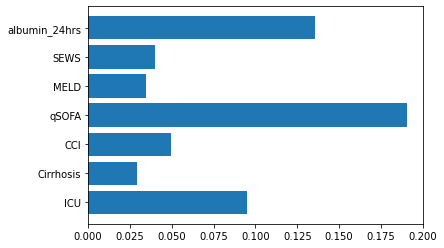

In [141]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
qSOFA            1.210015
albumin_24hrs    1.145515
ICU              1.099546
CCI              1.050711
SEWS             1.041000
MELD             1.034878
Cirrhosis        1.029727


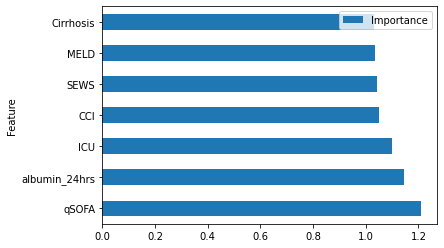

In [142]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [143]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [144]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1288  675]
 [ 645 1318]]


In [145]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1963
           1       0.66      0.67      0.67      1963

    accuracy                           0.66      3926
   macro avg       0.66      0.66      0.66      3926
weighted avg       0.66      0.66      0.66      3926



In [146]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[314 178]
 [ 47  88]]


In [147]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74       492
           1       0.33      0.65      0.44       135

    accuracy                           0.64       627
   macro avg       0.60      0.65      0.59       627
weighted avg       0.75      0.64      0.67       627



## 1: Decision Tree 

In [151]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.02869
Feature: Cirrhosis Score: 0.00000
Feature: CCI Score: 0.17524
Feature: qSOFA Score: 0.13590
Feature: MELD Score: 0.60298
Feature: SEWS Score: 0.03722
Feature: albumin_24hrs Score: 0.01997


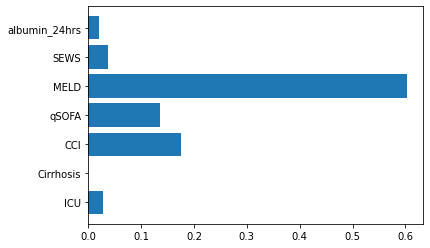

In [152]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [153]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [154]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1466  497]
 [ 723 1240]]


In [155]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1963
           1       0.71      0.63      0.67      1963

    accuracy                           0.69      3926
   macro avg       0.69      0.69      0.69      3926
weighted avg       0.69      0.69      0.69      3926



In [156]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[348 144]
 [ 65  70]]


In [157]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       492
           1       0.33      0.52      0.40       135

    accuracy                           0.67       627
   macro avg       0.58      0.61      0.59       627
weighted avg       0.73      0.67      0.69       627



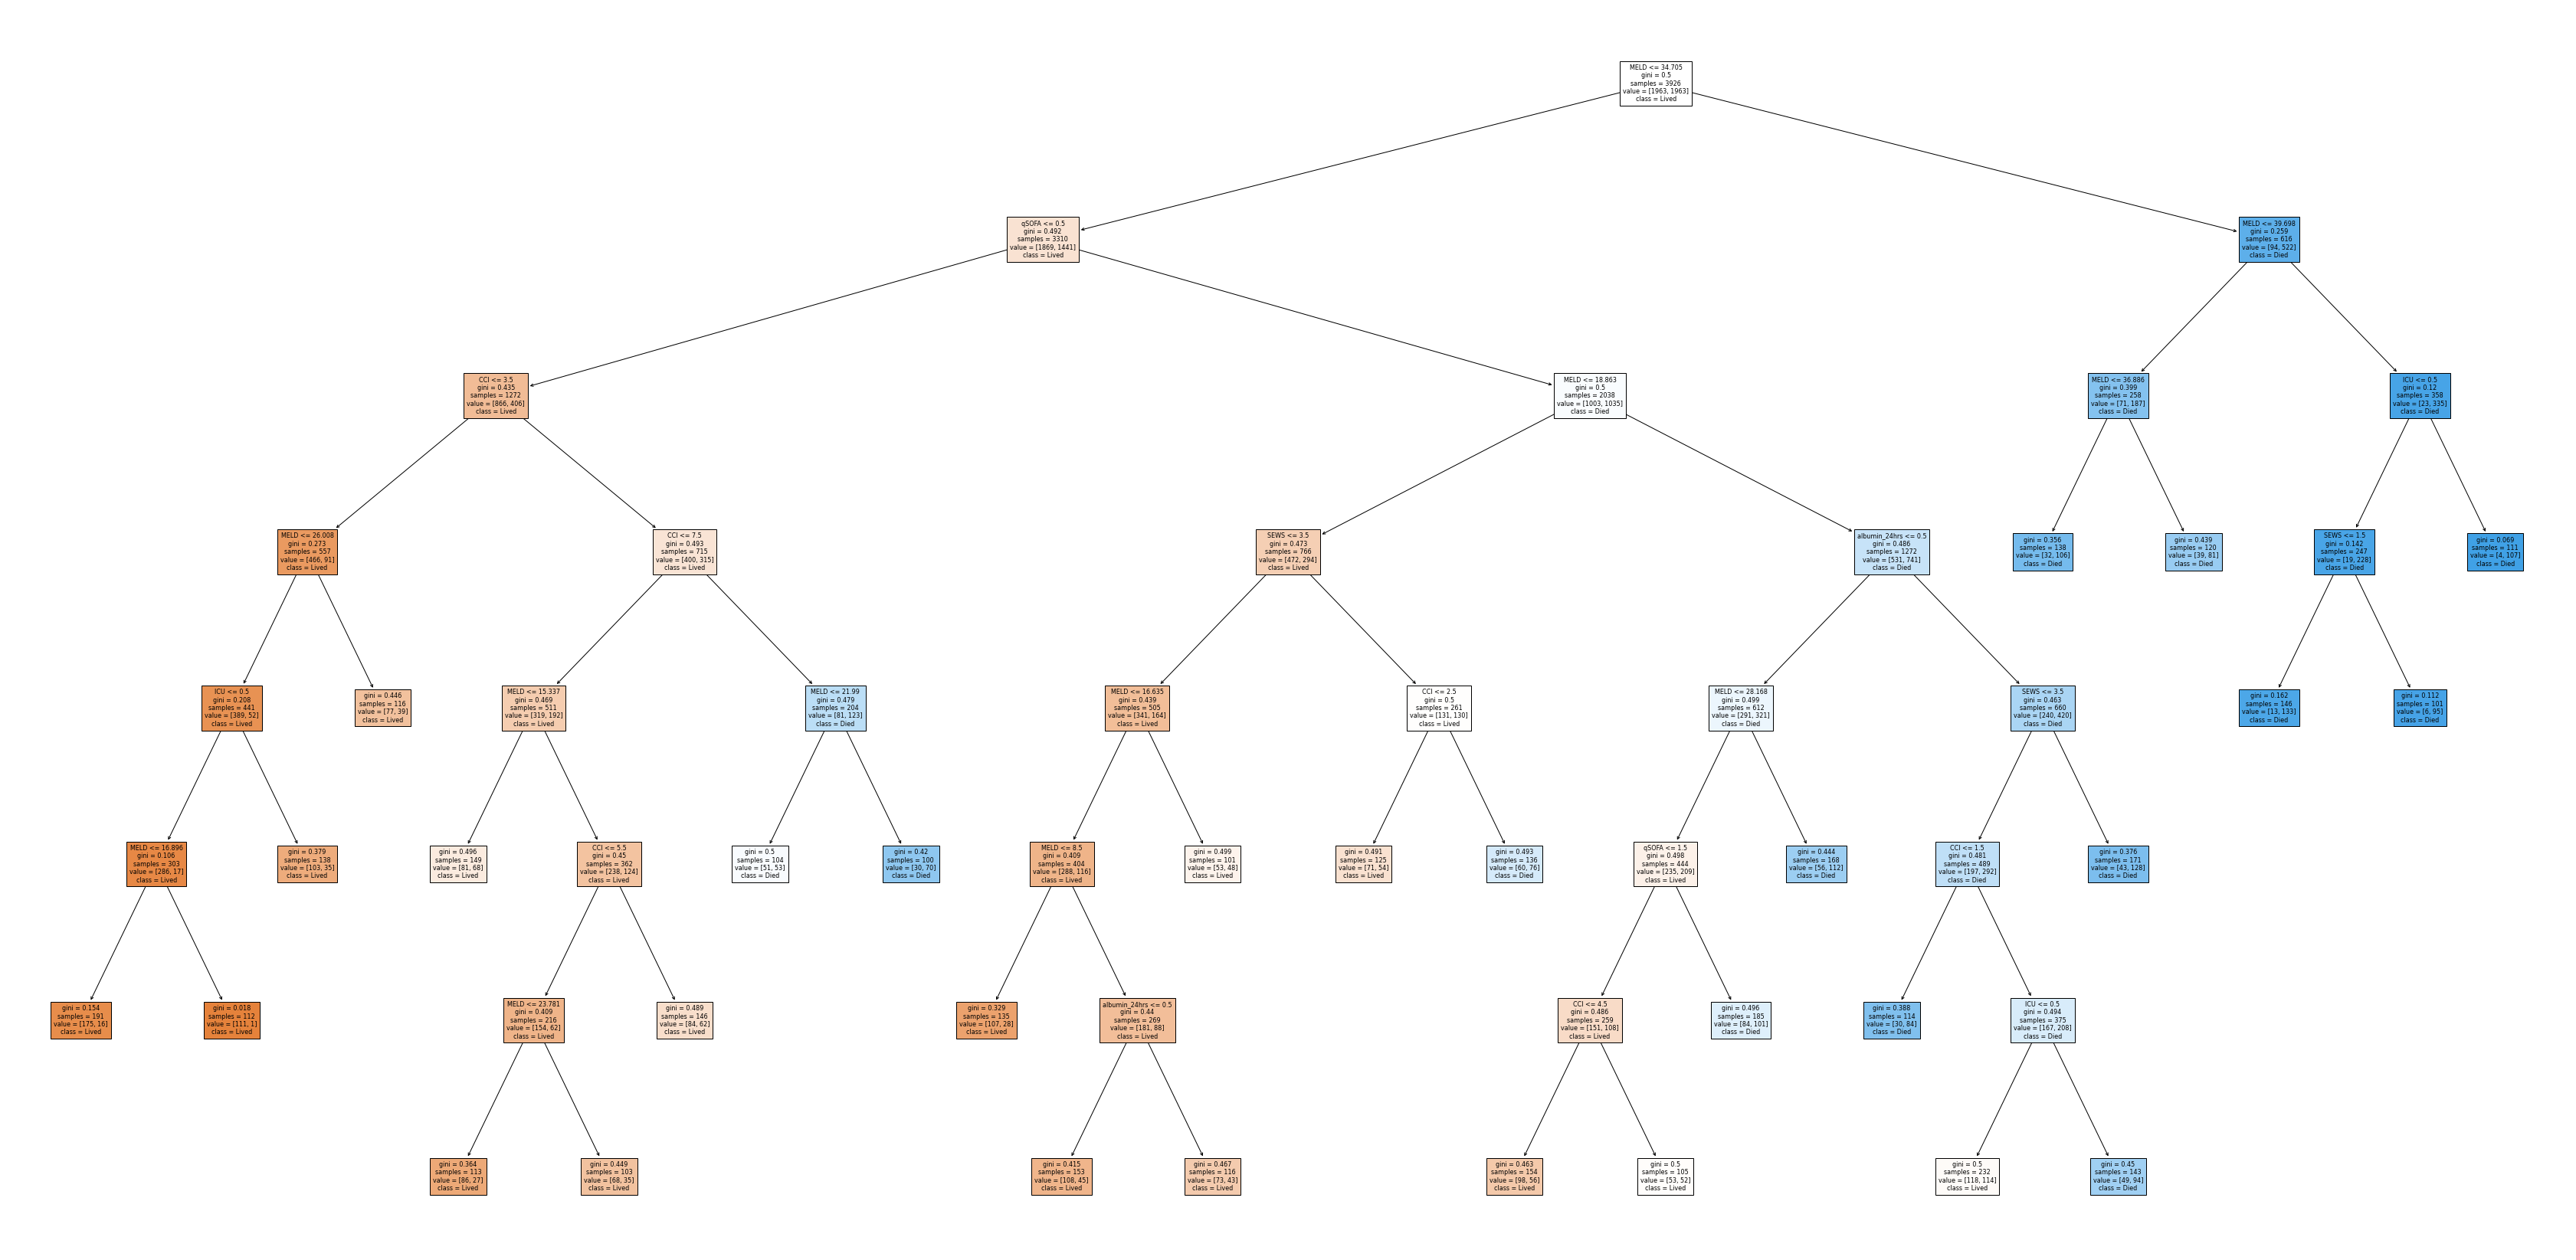

In [158]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [159]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DM_DT_D7_PSM_MATCHED.png')

True

## Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

In [224]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [225]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4497 2337]
 [2907 3927]]


In [226]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.61      0.66      0.63      6834
           1       0.63      0.57      0.60      6834

    accuracy                           0.62     13668
   macro avg       0.62      0.62      0.62     13668
weighted avg       0.62      0.62      0.62     13668



In [227]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1096  625]
 [ 160  197]]


In [228]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      1721
           1       0.24      0.55      0.33       357

    accuracy                           0.62      2078
   macro avg       0.56      0.59      0.54      2078
weighted avg       0.76      0.62      0.67      2078



Feature: ICU Score: 0.13846
Feature: mass_transfusion Score: 0.00615
Feature: total_transfusions Score: 0.15328
Feature: anemia_status Score: 0.10212
Feature: CCI Score: 0.19898
Feature: Cirrhosis Score: 0.09376
Feature: hemorrhagic Score: 0.08319
Feature: albumin_24hrs Score: 0.22406


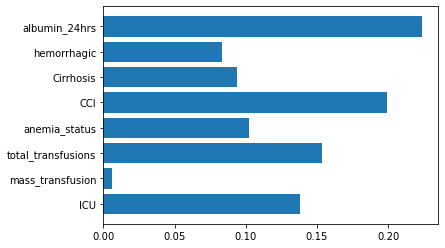

In [229]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()